### Dependancies used

In [1]:
import sys

sys.path.append("/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection/py")

from functions import *

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast

from PIL import Image,ImageDraw

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50, ResNet50_Weights


from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
HOME = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection"
#HOME = '/content/drive/MyDrive/ACT Coursework 2/Airbus-Aircraft-Detection/'
directory_path = os.path.join(HOME, 'airbus-aircrafts-sample-dataset')
image_path = os.path.join(directory_path, 'images')

### What is data augmentation?

Data augmentation is the process of generating more data out of a pre-existing dataset using various transformations to create new data, which can increase dataset diversity for training a machine learning algorithm.

### Why use data augmentation?

Data augmentation is very useful in situations where gathering more real data has ethical, financial or time restrictions and the current dataset is insufficient for accurate training and the diversity created by the adds more general features that help the model expect differences in features and better prepares it for unseen data which improves its overall performance.

In the case of the AirBus dataset being used, the dataset is quite small and both the desired and undesired features are very repetitive which can lead to overfitting as shown by the loss curve in out neural network.

### Methods of data augmentation

Data augmentation can be performed in a variety of ways to improve model diversity including but not limited to...
- Rotation: rotating images can help the model recognise models at different angles
- Cropping: removing sections of the image can simulate a closer image or focus on a particular feature
- Brightness: changing the brightness of the image can simulate variations in lighting conditions
- Gaussian Noise: adding noise can blur the image and simulate sensor noise and graininess.

Lets demonstrate this by taking a random data sample and using Albumentations to apply a [Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) transformation to it.

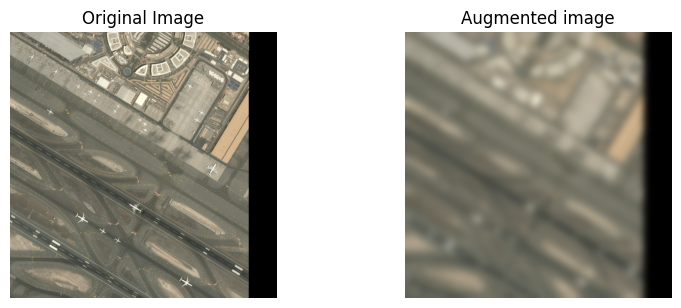

In [4]:
transform = A.Compose([
    A.GaussianBlur(blur_limit=(69, 421), sigma_limit=0, p=1.0), #Applies the Gaussain Blur with a probabilty of 1
    ToTensorV2(p=1.0)
])

random_image = np.random.choice(os.listdir(image_path))
image_path2 = os.path.join(image_path, random_image)
image = cv2.imread(image_path2)  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Apply the transformation multiple times
augmented_images = []
for _ in range(1):  # Generate N different augmented images
    augmented = transform(image=image)
    augmented_images.append(augmented['image'].permute(1, 2, 0).numpy())  # Convert back to numpy for visualisation

# Display the original and augmented images
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(augmented_images[0].astype(np.uint8))
plt.title(f"Augmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

Before in the neural network, Albumentations was used to convert the images into tensors so PyTorch could interpret them, this function can be modified to include the aformentiond augmentation processes and create additional images for training using these transformations. To remove potential bias in the transformations, which transformation is applied is decided randomly, and each transformation has an equal likelihood of occuring.

In [5]:
def get_train_transform():
    return A.Compose(
        [A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),  # Apply Gaussian Noise
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.25),  # Adjust Brightness and Contrast
                A.ChannelShuffle(p=0.25),  # Randomly shuffle image channels
                A.Downscale(scale_min=0.5, scale_max=0.9, interpolation=0, p=0.25),  # Downscale the image pixel size
                ],
                p=1.0,
            ),
            ToTensorV2(p=1.0),  # Convert to PyTorch tensor
        ]
    )

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

Applying one random transformation to each image in the dataset effectively doubles the size of the dataset, and this can be extrapolated further by applying multiple different transformations to the original images or applying additional transformations to already transformed images.

### Neural Network code

In [6]:
HOME = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection"
#HOME = '/content/drive/MyDrive/ACT Coursework 2/Airbus-Aircraft-Detection/'
directory_path = os.path.join(HOME, 'airbus-aircrafts-sample-dataset')
image_path = os.path.join(directory_path, 'images')
annotations_path = os.path.join(directory_path, 'annotations.csv')
annotations = pd.read_csv(annotations_path)
annotations.head()

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane


In [7]:
df = pd.read_csv(annotations_path, converters={'geometry': f, 'class': lambda o: 'Aircraft'})

# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'w'] = df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'h'] = df.loc[:,'bounds'].apply(getHeight)
df.loc[:,'x'] = df.loc[:,'bounds'].apply(getX)
df.loc[:,'y'] = df.loc[:,'bounds'].apply(getY)
df.head(10)

,id,image_id,geometry,class,bounds,w,h,x,y
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft,"(135, 522, 245, 600)",110,78,135,522
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft,"(1025, 284, 1125, 384)",100,100,1025,284
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft,"(1058, 1503, 1130, 1568)",72,65,1058,1503
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft,"(813, 1518, 885, 1604)",72,86,813,1518
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft,"(594, 938, 657, 1012)",63,74,594,938
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft,"(451, 725, 524, 798)",73,73,451,725
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft,"(1543, 1437, 1614, 1497)",71,60,1543,1437
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft,"(1485, 1370, 1561, 1437)",76,67,1485,1370
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft,"(1968, 1624, 2053, 1687)",85,63,1968,1624
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft,"(1659, 1674, 1733, 1746)",74,72,1659,1674


In [8]:
class AircraftDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        # Initializes the custom Dataset to store the unique image IDs, DataFrame, image directory, and optionally any image transformations.
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms  # Optional data augmentation or preprocessing, currently set to None.

    def __len__(self) -> int:
        # returns the number of unique images in the dataset
        return self.image_ids.shape[0]

    def __getitem__(self, idx: int):
        # Loads the image at the given index, converts it to a tensor, reads any annotations and labels
        # and returns them as a tuple

        # Get the image ID for the given index.
        image_id = self.image_ids[idx]

        # Filter the DataFrame for records corresponding to this image ID.
        records = self.df[self.df['image_id'] == image_id]

        # Load the image from the image directory using OpenCV.
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)

        # Convert the image from BGR to RGB and normalize pixel values to [0, 1].
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0  # Normalize pixel values to the range [0, 1].

        # Extract bounding box coordinates from the records.
        boxes = records[['x', 'y', 'w', 'h']].values
        # Convert from [x, y, w, h] format to [x_min, y_min, x_max, y_max].
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x_min + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y_min + height

        # Compute the area of each bounding box.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)  # Convert to PyTorch tensor.

        # Assign a label of 1 to all bounding boxes (single-class dataset).A
        labels = torch.ones((records.shape[0],), dtype=torch.int64).numpy()

        # Assume that all instances are not part of a crowd (set `iscrowd` to 0).
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # Create the target dictionary with required metadata.
        target = {
            'boxes': boxes,  # Bounding boxes.
            'labels': labels,  # Object labels.
            'image_id': torch.tensor([idx]),  # Image index as tensor.
            'area': area,  # Area of each bounding box.
            'iscrowd': iscrowd  # Crowd annotations.
        }

        # If transformations are specified, apply them to the image and bounding boxes.
        if self.transforms:
            # Prepare a sample dictionary for the transformations.
            sample = {
                'image': image,  # Input image.
                'bboxes': target['boxes'],  # Bounding boxes.
                'labels': labels  # Labels for the bounding boxes.
            }
            # Apply transformations.
            sample = self.transforms(**sample)
            # Update the image and bounding boxes after transformation.
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        # Return the processed image, target dictionary, and image ID.
        return image, target, image_id

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn('DEFAULT')

C:\Users\louie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [10]:
num_classes = 2  # 2 total class: aircraft and background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
unique_img = df.image_id.unique() # Get uniqusednge
train_inds, test_inds = train_test_split(range(unique_img.shape[0]), test_size= 0.1) # 90% train, 10% test

train_df = df.iloc[train_inds] # Get training data
test_df = df.iloc[test_inds] # Get test data

In [12]:
def collate_fn(batch): # Function to collate data samples into a batch
    return tuple(zip(*batch))

train_dataset = AircraftDataset(train_df, image_path, get_train_transform())
test_dataset = AircraftDataset(test_df, image_path, get_test_transform())

In [13]:
# split the dataset randomly into a train set and a test set removing any potential bias
indices = torch.randperm(len(train_dataset)).tolist()

In [14]:
# define training and validation data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16, # how many samples per batch to load
    shuffle=True, # disabling shuffling of the data, setting to True will randomize the data for each epoch, which prevents overfitting to the order of the data
                   # setting to False ensures a deterministic order of the data, which is good for valiadation and testing runs
    collate_fn=collate_fn # calling collate function
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

In [15]:
# moves model to GPU if avaliable, otherwise CPU is used
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [16]:
# converts the data loader to an iterator which allows for manual stepping through the batches
images, targets, image_ids = next(iter(train_data_loader))

# moves images and targets to GPU if avaliable to use
images = [image.to(device) for image in images]
targets = [{k: v.to(device) if torch.is_tensor(v) else torch.from_numpy(v).to(device) for k, v in t.items()} for t in targets]

In [17]:
# moves the tensor to the CPU as numpy operations are incompatible with GPU tensors
# converts the tensor to a numpy array and sets the data type to int32 to allow for use with downstream functions or visualization tools
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..220.0].


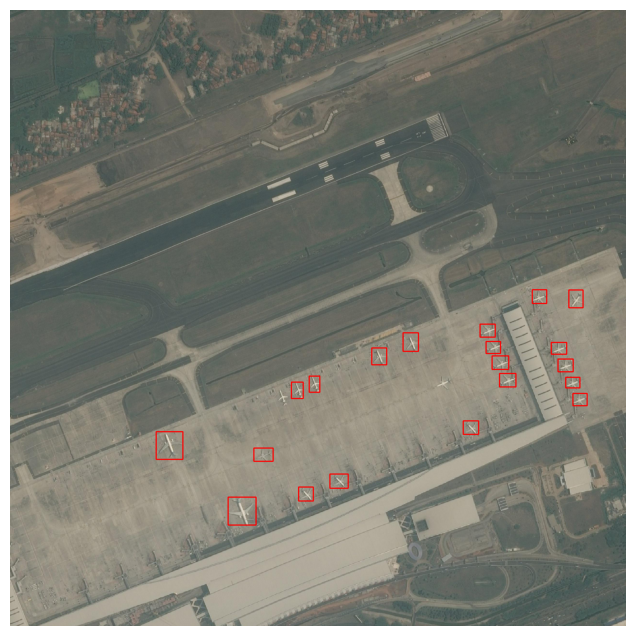

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

### Retraining the neural network with the augmented data
Training the neural network is the same as before, but with a larger and more varied dataset, we'll use the same parameters and hyperparameters as before to help illustrate the difference in the loss curve. As the data is now more varied, there should be more oscillations in the loss curves in the early epochs, but the curve should have a smoother convergence due to the model being more robust and being better at handling varied data.

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20 # number of times the model will be trained on the entire dataset

In [20]:
# Create lists to store loss values for training and validation
train_loss_values = []
train_acc = []

train_loss_hist = Averager()

for epoch in range(num_epochs):
    # Reset the training loss history
    train_loss_hist.reset()

    # Training Loop
    model.train()  # Set the model to training mode
    for images, targets, image_ids in train_data_loader:  # iterate over the training data loader
        # Move image tensors and annotations to the specified device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if torch.is_tensor(v) else torch.from_numpy(v).to(device) for k, v in t.items()} for t in targets]

        train_loss_dict = model(images, targets)  # Passes images and targets to the model and returns a loss dictionary

        train_losses = sum(train_loss for train_loss in train_loss_dict.values())  # Computes the sum of all losses
        train_loss_value = train_losses.item()  # Converts the loss value to a Python scalar

        train_loss_hist.send(train_loss_value)  # Sends the loss value to the loss history object
        train_loss_values.append(train_loss_value)  # Append the current loss value to the list for plotting

        optimizer.zero_grad()  # Clear gradients
        train_losses.backward()  # Backpropagation
        optimizer.step()  # Update model parameter

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss_hist.value:.4f}") # Print the average loss for the epoch

Epoch [1/20] - Train Loss: 4.4430
Epoch [2/20] - Train Loss: 1.3720
Epoch [3/20] - Train Loss: 1.6894
Epoch [4/20] - Train Loss: 1.4881
Epoch [5/20] - Train Loss: 1.3715
Epoch [6/20] - Train Loss: 1.3228
Epoch [7/20] - Train Loss: 1.2002
Epoch [8/20] - Train Loss: 1.1766
Epoch [9/20] - Train Loss: 1.1086
Epoch [10/20] - Train Loss: 1.0950
Epoch [11/20] - Train Loss: 0.9967
Epoch [12/20] - Train Loss: 1.1698
Epoch [13/20] - Train Loss: 0.9523
Epoch [14/20] - Train Loss: 0.9610
Epoch [15/20] - Train Loss: 0.9825
Epoch [16/20] - Train Loss: 0.8529
Epoch [17/20] - Train Loss: 0.8893
Epoch [18/20] - Train Loss: 0.8776
Epoch [19/20] - Train Loss: 0.8326
Epoch [20/20] - Train Loss: 0.7867


### Interepting the new results
The new loss curve exhibits the expected fluctuations in the early stages of training, due to both the increase in data being processed and the additional variance in the new data added, with more variance ocurring with more agressive transformations such as noise. However the new curve does exhibit osciliations in the later epochs too, this is due to the model having a hard time training on the varied data, if the number of epochs were increased or less agressive transformations were chosen, the expected smoother convergence would occur due to the model being forced to learn more from additional features instead of relying too heavily on specific features and overfitting would be mitigated.

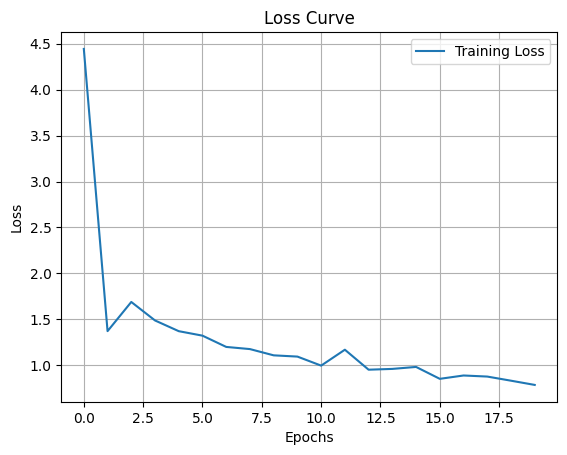

In [21]:
# Plot the loss curve
plt.figure()
plt.plot(train_loss_values, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

### Image drawing code

In [22]:
model.eval() # in evaluation mode, dropout layers are disabeled, mean and variance statistics aren't updated
images, targets, image_ids = iter(test_data_loader).__next__() # converts the PyTorch data loader to an iterator and retrieves the next batch of data
data=iter(test_data_loader).__next__()

In [23]:
output=model([images[1].to(device)]) # passes an image from the batch to the model and returns the the predicted bounding boxes, class labels and confidence scores

In [24]:
# extracts the predicted bounding boxes and confidence scores
out_box=output[0]['boxes']
out_scores=output[0]['scores']
len(out_box)

67

### Model Evaluation
The newly trained model is still capable of detecting aircraft with a 90% confidence score in the unaugmented dataset, but now it'll have an easier time finding the desired features in new unseen data as well.

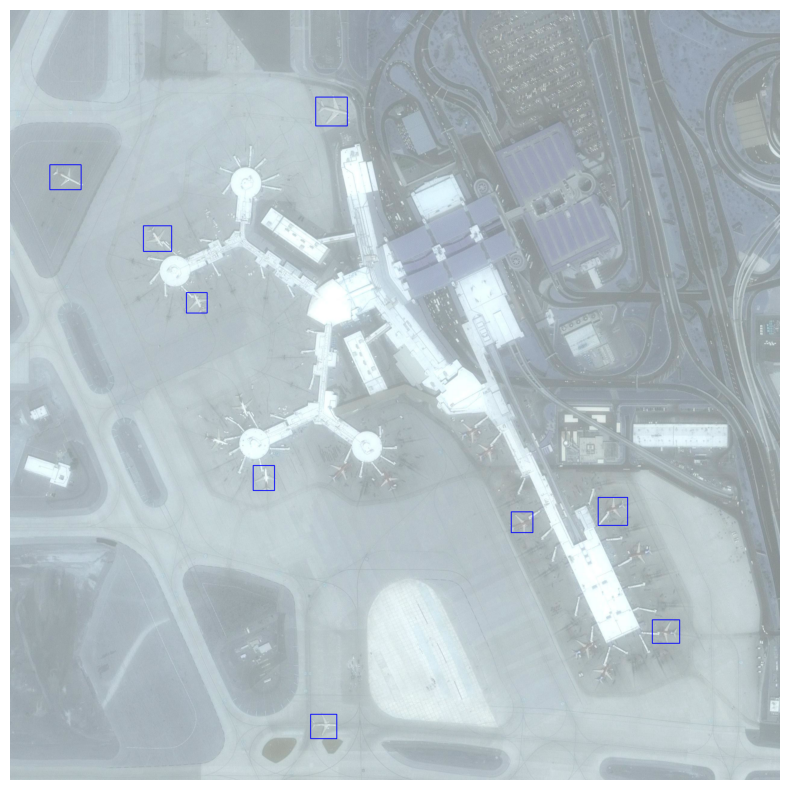

In [25]:
im=(images[1].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8') #

for i in range(len(out_box)):
    if out_scores[i] >= 0.9:
        # Draw the rectangle on the image
        box = list(map(int, out_box[i]))  # Convert box coordinates to integers
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)  # Blue rectangle

# Convert the image from BGR to RGB for displaying with matplotlib
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

### Saving the model
The models training parameters and hyperparameters can be saved using `torch.save` to be used again for future models

In [26]:
model_path = os.path.join(HOME, 'py/Question 2/fasterrcnn_resnet50_fpn.pth')
torch.save(model.state_dict(), model_path)  # saves the trained model for future use

### Conclusion
Data augmentation can significantly enhance the performance and adaptability of a neural network by increasing the diversity of training data. While it can lead to higher initial loss and slower convergence due to the added variability as shown here, models trained with data augmentation typically achieve better validation performance and are more resilient to variations in real-world data. With the proper parameter and hyperparameters, data augmentation can a powerful tool for accuquiring additional data when obtaining real data poses to be a financial/ethical burden.